# Time Series Prediction

**Objectives**
 1. Build a linear, DNN and CNN model in Keras.
 2. Build a simple RNN model and a multi-layer RNN model in Keras.
 
In this lab we will with a linear, DNN and CNN model 

Since the features of our model are sequential in nature, we'll next look at how to build various RNN models in Keras. We'll start with a simple RNN model and then see how to create a multi-layer RNN in Keras.

We will be exploring a lot of different model types in this notebook.


In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!pip install --user google-cloud-bigquery==1.25.0

     |████████████████████████████████| 169 kB 7.9 MB/s eta 0:00:01
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tfx 0.23.0 requires attrs<20,>=19.3.0, but you'll have attrs 20.3.0 which is incompatible.
tfx 0.23.0 requires google-resumable-media<0.7.0,>=0.6.0, but you'll have google-resumable-media 0.5.1 which is incompatible.
tfx 0.23.0 requires kubernetes<12,>=10.0.1, but you'll have kubernetes 12.0.0 which is incompatible.
tfx 0.23.0 requires pyarrow<0.18,>=0.17, but you'll have pyarrow 2.0.0 which is incompatible.
google-cloud-storage 1.30.0 requires google-resumable-media<2.0dev,>=0.6.0, but you'll have google-resumable-media 0.5.1 which is incompatible.


**Note**: Restart your kernel to use updated packages.

Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

## Load necessary libraries and set up environment variables

In [3]:
PROJECT = "qwiklabs-gcp-04-61ae09ee3a9c" # REPLACE WITH YOUR PROJECT NAME
BUCKET = "qwiklabs-gcp-04-61ae09ee3a9c" # REPLACE WITH YOUR BUCKET
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

In [4]:
%env 
PROJECT = PROJECT
BUCKET = BUCKET
REGION = REGION

In [5]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from google.cloud import bigquery
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, DenseFeatures,
                                     Conv1D, MaxPool1D,
                                     Reshape, RNN,
                                     LSTM, GRU, Bidirectional)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For reproducible results.
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

## Explore time series data

We'll start by pulling a small sample of the time series data from Big Query and write some helper functions to clean up the data for modeling. We'll use the data from the `percent_change_sp500` table in BigQuery. The `close_values_prior_260` column contains the close values for any given stock for the previous 260 days. 

In [6]:
%%time
bq = bigquery.Client(project=PROJECT)

bq_query = '''
#standardSQL
SELECT
  symbol,
  Date,
  direction,
  close_values_prior_260
FROM
  `stock_market.eps_percent_change_sp500`
LIMIT
  100
'''


CPU times: user 8.83 ms, sys: 112 µs, total: 8.94 ms
Wall time: 15.9 ms


The function `clean_data` below does three things:
 1. First, we'll remove any inf or NA values
 2. Next, we parse the `Date` field to read it as a string.
 3. Lastly, we convert the label `direction` into a numeric quantity, mapping 'DOWN' to 0, 'STAY' to 1 and 'UP' to 2. 

In [7]:
def clean_data(input_df):
    """Cleans data to prepare for training.

    Args:
        input_df: Pandas dataframe.
    Returns:
        Pandas dataframe.
    """
    df = input_df.copy()

    # Remove inf/na values.
    real_valued_rows = ~(df == np.inf).max(axis=1)
    df = df[real_valued_rows].dropna()

    # TF doesn't accept datetimes in DataFrame.
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # TF requires numeric label.
    df['direction_numeric'] = df['direction'].apply(lambda x: {'DOWN': 0,
                                                               'STAY': 1,
                                                               'UP': 2}[x])
    return df

## Read data and preprocessing

Before we begin modeling, we'll preprocess our features by scaling to the z-score. This will ensure that the range of the feature values being fed to the model are comparable and should help with convergence during gradient descent.

In [8]:
STOCK_HISTORY_COLUMN = 'close_values_prior_260'
COL_NAMES = ['day_' + str(day) for day in range(0, 260)]
LABEL = 'direction_numeric'

In [9]:
def _scale_features(df):
    """z-scale feature columns of Pandas dataframe.

    Args:
        features: Pandas dataframe.
    Returns:
        Pandas dataframe with each column standardized according to the
        values in that column.
    """
    avg = df.mean()
    std = df.std()
    return (df - avg) / std


def create_features(df, label_name):
    """Create modeling features and label from Pandas dataframe.

    Args:
        df: Pandas dataframe.
        label_name: str, the column name of the label.
    Returns:
        Pandas dataframe
    """
    # Expand 1 column containing a list of close prices to 260 columns.
    time_series_features = df[STOCK_HISTORY_COLUMN].apply(pd.Series)

    # Rename columns.
    time_series_features.columns = COL_NAMES
    time_series_features = _scale_features(time_series_features)

    # Concat time series features with static features and label.
    label_column = df[LABEL]

    return pd.concat([time_series_features,
                      label_column], axis=1)

### Make train-eval-test split

Next, we'll make repeatable splits for our train/validation/test datasets and save these datasets to local csv files. The query below will take a subsample of the entire dataset and then create a 70-15-15 split for the train/validation/test sets. 

In [11]:
def _create_split(phase):
    """Create string to produce train/valid/test splits for a SQL query.

    Args:
        phase: str, either TRAIN, VALID, or TEST.
    Returns:
        String.
    """
    floor, ceiling = '2002-11-01', '2010-07-01'
    if phase == 'VALID':
        floor, ceiling = '2010-07-01', '2011-09-01'
    elif phase == 'TEST':
        floor, ceiling = '2011-09-01', '2012-11-30'
    return '''
    WHERE Date >= '{0}'
    AND Date < '{1}'
    '''.format(floor, ceiling)


def create_query(phase):
    """Create SQL query to create train/valid/test splits on subsample.

    Args:
        phase: str, either TRAIN, VALID, or TEST.
        sample_size: str, amount of data to take for subsample.
    Returns:
        String.
    """
    basequery = """
    #standardSQL
    SELECT
      symbol,
      Date,
      direction,
      close_values_prior_260
    FROM
      `stock_market.eps_percent_change_sp500`
    """
    
    return basequery + _create_split(phase)

## Modeling

For experimentation purposes, we'll train various models using data we can fit in memory using the `.csv` files we created above. 

In [12]:
N_TIME_STEPS = 260
N_LABELS = 3

Xtrain = pd.read_csv('stock-train.csv')
Xvalid = pd.read_csv('stock-valid.csv')

ytrain = Xtrain.pop(LABEL)
yvalid  = Xvalid.pop(LABEL)

ytrain_categorical = to_categorical(ytrain.values)
yvalid_categorical = to_categorical(yvalid.values)

To monitor training progress and compare evaluation metrics for different models, we'll use the function below to plot metrics captured from the training job such as training and validation loss or accuracy.

In [16]:
Xtrain.head()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_250,day_251,day_252,day_253,day_254,day_255,day_256,day_257,day_258,day_259
0,-0.144946,-0.135877,-0.146586,-0.149944,-0.151658,-0.149648,-0.150216,-0.151742,-0.135856,-0.127655,...,-0.175549,-0.175757,-0.164736,-0.172003,-0.183098,-0.192609,-0.185822,-0.213345,-0.216334,-0.217794
1,-0.458200,-0.455591,-0.449417,-0.435703,-0.440224,-0.451866,-0.436883,-0.506776,-0.502588,-0.502273,...,-0.294629,-0.291526,-0.280120,-0.279749,-0.277877,-0.275013,-0.273712,-0.272388,-0.272866,-0.275396
2,-0.499667,-0.462806,-0.493355,-0.533280,-0.523828,-0.526971,-0.543039,-0.578633,-0.543261,-0.551535,...,-0.454946,-0.447208,-0.449216,-0.449001,-0.425582,-0.423695,-0.406763,-0.405733,-0.396572,-0.396778
3,-0.391268,-0.341053,-0.369879,-0.386690,-0.375050,-0.316947,-0.345732,-0.349629,-0.341235,-0.357845,...,-0.647680,-0.645668,-0.649038,-0.648785,-0.642600,-0.641747,-0.644087,-0.642570,-0.634895,-0.637778
4,-0.144946,-0.135877,-0.146586,-0.149944,-0.151658,-0.149648,-0.150216,-0.151742,-0.135856,-0.127655,...,-0.175549,-0.175757,-0.164736,-0.172003,-0.183098,-0.192609,-0.185822,-0.213345,-0.216334,-0.217794


In [15]:
ytrain.head()

0    2
1    2
2    2
3    2
4    2
Name: direction_numeric, dtype: int64

In [21]:
Xvalid.head()


,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_250,day_251,day_252,day_253,day_254,day_255,day_256,day_257,day_258,day_259
0,-0.445308,-0.464056,-0.472228,-0.460390,-0.458222,-0.458362,-0.448449,-0.443740,-0.456983,-0.470379,...,-0.452690,-0.470656,-0.461597,-0.458729,-0.454458,-0.432277,-0.438652,-0.463850,-0.478945,-0.483748
1,-0.911869,-0.914515,-0.914645,-0.911092,-0.903038,-0.906745,-0.914415,-0.907080,-0.906184,-0.911941,...,-0.938796,-0.933844,-0.929590,-0.930278,-0.931648,-0.929182,-0.927178,-0.928457,-0.931890,-0.934536
2,-0.951657,-0.958659,-0.962615,-0.956611,-0.958111,-0.954450,-0.952971,-0.947278,-0.951882,-0.957211,...,-0.951750,-0.947322,-0.945387,-0.943706,-0.943297,-0.938810,-0.935807,-0.932374,-0.936204,-0.939647
3,0.265190,0.279272,0.282469,0.272621,0.261721,0.266147,0.279886,0.275601,0.211284,0.220762,...,0.002921,0.007198,0.003631,0.000776,-0.004909,-0.019073,-0.026220,-0.031367,-0.034430,-0.031387
4,-0.918500,-0.923533,-0.927469,-0.921234,-0.917395,-0.920375,-0.925464,-0.921655,-0.919846,-0.928058,...,-0.931222,-0.924132,-0.925245,-0.927909,-0.928095,-0.923877,-0.922079,-0.922580,-0.924439,-0.927262


In [22]:
yvalid.head()

0    2
1    2
2    2
3    2
4    2
Name: direction_numeric, dtype: int64

In [23]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

### Baseline

Before we begin modeling in Keras, let's create a benchmark using a simple heuristic. Let's see what kind of accuracy we would get on the validation set if we predict the majority class of the training set. 

In [24]:
sum(yvalid == ytrain.value_counts().idxmax()) / yvalid.shape[0]

0.29490392648287383

Ok. So just naively guessing the most common outcome `UP` will give about 29.5% accuracy on the validation set. 

### Linear model

We'll start with a simple linear model, mapping our sequential input to a single fully dense layer. 

In [25]:
model = Sequential()
model.add(Dense(units=N_LABELS,
                activation='softmax',
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [26]:
history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=30,
                    verbose=0)

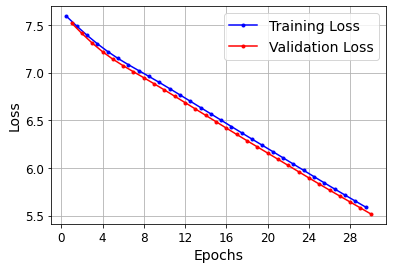

In [27]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

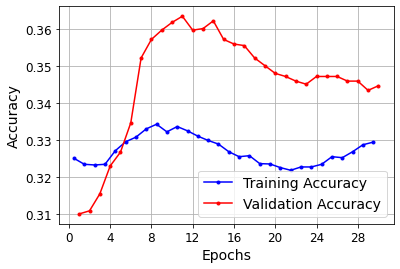

In [28]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

The accuracy seems to level out pretty quickly. To report the accuracy, we'll average the accuracy on the validation set across the last few epochs of training.

In [29]:
np.mean(history.history['val_accuracy'][-5:])

0.3453634023666382

### Deep Neural Network

The linear model is an improvement on our naive benchmark. Perhaps we can do better with a more complicated model. Next, we'll create a deep neural network with Keras. We'll experiment with a two layer DNN here but feel free to try a more complex model or add any other additional techniques to try an improve your performance. 

In [30]:
dnn_hidden_units = [16, 8]

model = Sequential()
for layer in dnn_hidden_units:
    model.add(Dense(units=layer,
                    activation="relu"))

model.add(Dense(units=N_LABELS,
                activation="softmax",
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=10,
                    verbose=0)

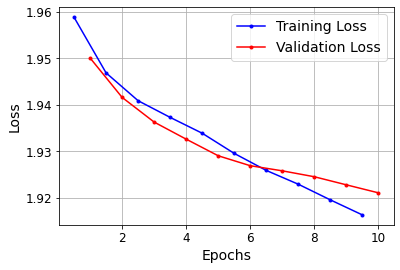

In [31]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

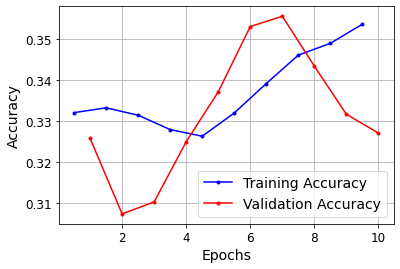

In [32]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [33]:
np.mean(history.history['val_accuracy'][-5:])

0.3421052634716034

### Convolutional Neural Network

The DNN does slightly better. Let's see how a convolutional neural network performs. 

A 1-dimensional convolutional can be useful for extracting features from sequential data or deriving features from shorter, fixed-length segments of the data set. Check out the documentation for how to implement a [Conv1d in Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D). Max pooling is a downsampling strategy commonly used in conjunction with convolutional neural networks. Next, we'll build a CNN model in Keras using the `Conv1D` to create convolution layers and `MaxPool1D` to perform max pooling before passing to a fully connected dense layer. 

In [34]:
model = Sequential()

# Convolutional layer
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
model.add(Conv1D(filters=5,
                 kernel_size=5,
                 strides=2,
                 padding="valid",
                 input_shape=[None, 1]))
model.add(MaxPool1D(pool_size=2,
                    strides=None,
                    padding='valid'))


# Flatten the result and pass through DNN.
model.add(tf.keras.layers.Flatten())
model.add(Dense(units=N_TIME_STEPS//4,
                activation="relu"))

model.add(Dense(units=N_LABELS, 
                activation="softmax",
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=10,
                    verbose=0)

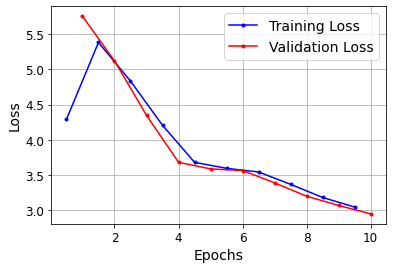

In [35]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

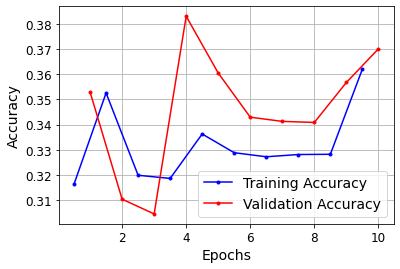

In [36]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [203]:
np.mean(history.history['val_accuracy'][-5:])

0.34569758

### Recurrent Neural Network

RNNs are particularly well-suited for learning sequential data. They retain state information from one iteration to the next by feeding the output from one cell as input for the next step. In the cell below, we'll build a RNN model in Keras. The final state of the RNN is captured and then passed through a fully connected layer to produce a prediction.

In [37]:
model = Sequential()

# Reshape inputs to pass through RNN layer.
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))
model.add(LSTM(N_TIME_STEPS // 8,
               activation='relu',
               return_sequences=False))

model.add(Dense(units=N_LABELS,
                activation='softmax',
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

# Create the model.
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=40,
                    verbose=0)

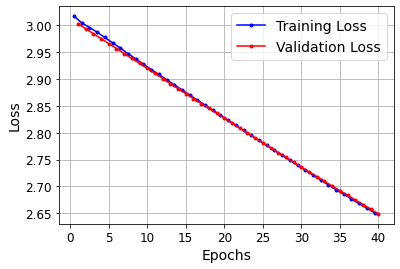

In [38]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

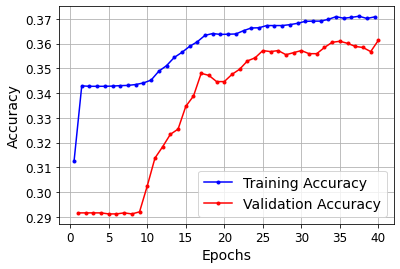

In [39]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [41]:
np.mean(history.history['val_accuracy'][-5:])

0.3590643286705017

### Multi-layer RNN

Next, we'll build multi-layer RNN. Just as multiple layers of a deep neural network allow for more complicated features to be learned during training, additional RNN layers can potentially learn complex features in sequential data. For a multi-layer RNN the output of the first RNN layer is fed as the input into the next RNN layer.

In [ ]:
rnn_hidden_units = [N_TIME_STEPS // 16,
                    N_TIME_STEPS // 32]

model = Sequential()

# Reshape inputs to pass through RNN layer.
model.add(Reshape(target_shape=[N_TIME_STEPS, 1]))

for layer in rnn_hidden_units[:-1]:
    model.add(GRU(units=layer,
                  activation='relu',
                  return_sequences=True))

model.add(GRU(units=rnn_hidden_units[-1],
              return_sequences=False))
model.add(Dense(units=N_LABELS,
                activation="softmax",
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=Xtrain.values,
                    y=ytrain_categorical,
                    batch_size=Xtrain.shape[0],
                    validation_data=(Xvalid.values, yvalid_categorical),
                    epochs=50,
                    verbose=1)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 1.8452 - accuracy: 0.3179 - val_loss: 1.8499 - val_accuracy: 0.3124
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 1.8422 - accuracy: 0.3384 - val_loss: 1.8476 - val_accuracy: 0.3191
Epoch 3/50
1/1 [==============================] - 1s 934ms/step - loss: 1.8393 - accuracy: 0.3382 - val_loss: 1.8452 - val_accuracy: 0.3237
Epoch 4/50
1/1 [==============================] - 1s 827ms/step - loss: 1.8365 - accuracy: 0.3423 - val_loss: 1.8427 - val_accuracy: 0.3262
Epoch 5/50
1/1 [==============================] - 1s 882ms/step - loss: 1.8338 - accuracy: 0.3492 - val_loss: 1.8400 - val_accuracy: 0.3325
Epoch 6/50
1/1 [==============================] - 1s 941ms/step - loss: 1.8310 - accuracy: 0.3531 - val_loss: 1.8375 - val_accuracy: 0.3312
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 1.8284 - accuracy: 0.3576 - val_loss: 1.8349 - val_accuracy: 0.3300
Epoch 8/50
1/1 [=============

In [ ]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

In [ ]:
plot_curves(history.history['accuracy'],
            history.history['val_accuracy'],
            label='Accuracy')

In [ ]:
np.mean(history.history['val_accuracy'][-5:])

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License